In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [2]:
d1 = json.load(open('train_01.json'))
d2 = json.load(open('train_02.json'))

In [4]:
d = []
r = {'inside':1, 'outside':-1}
for k in d1.keys():
    _df = pd.DataFrame(d1[k], columns=['A', 'B'])
    _df['class'] = r[k]
    d.append(_df)
df1 = pd.concat(d, axis=0, ignore_index=True)

In [5]:
d = []
r = {'inside':1, 'outside':-1}
for k in d2.keys():
    _df = pd.DataFrame(d2[k], columns=['A', 'B'])
    _df['class'] = r[k]
    d.append(_df)
df2 = pd.concat(d, axis=0, ignore_index=True)

In [6]:
df1

,A,B,class
0,0.729520,0.728634,1
1,0.826506,0.940316,1
2,0.602314,0.489100,1
3,0.792430,0.972460,1
4,0.373906,0.380795,1
5,0.521383,0.701165,1
6,0.579949,0.860210,1
7,0.447271,0.232087,1
8,0.826693,0.970862,1
9,0.209609,0.079489,1


In [7]:
def plot(df):
    plt.figure(figsize=(7,7))
    font = {'weight' : 'bold', 'size'   : 15}
    plt.rc('font', **font)
    try:
        df1, df2 = [x for _, x in df.groupby(df['class'] == -1)]
        plt.scatter(df1.A, df1.B)
        plt.scatter(df2.A, df2.B)
    except Exception:
        print('Only one class was detected')
        plt.scatter(df.A, df.B)
    plt.xlabel('A')
    plt.ylabel('B')
    plt.legend(['inside', 'outside'])

In [17]:
train1, test1 = train_test_split(df1, test_size=0.2)

In [ ]:
train2, test2 = train_test_split(df2, test_size=0.2)

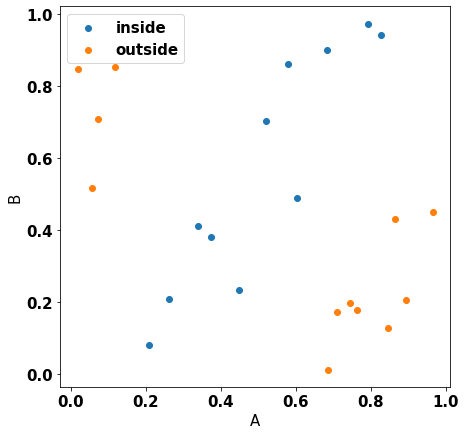

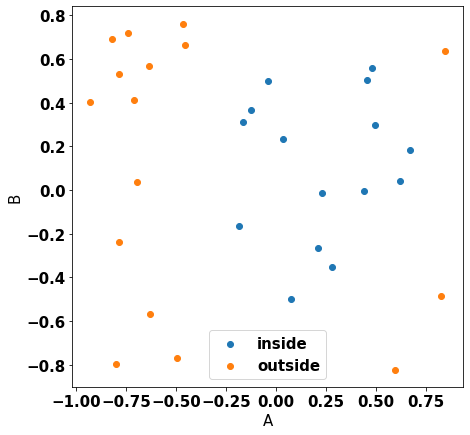

In [9]:
plot(train1)
plot(train2)

# so we need to use ellipses

In [23]:
class Classifier:
    def __init__(self, train):
        self.df = train
        self.X = self.df[['A', 'B']]
        self.X['A2'] = self.X.A*self.X.A
        self.X['B2'] = self.X.B*self.X.B
        self.X['AB'] = self.X.A*self.X.B
        self.X['C'] = 1
        self.y = train['class']
        self.w = np.zeros(6)
        self.classify()
        self.plot(train)
    
    def fix(self, X, y):
        self.w += y*X/np.linalg.norm(X)
        
    def check(self):
        res = self.y * np.sum(self.w * self.X, axis=1)
        bad = self.X[res <= 0]
        try:
            return False, bad.index[0]
        except Exception:
            return True, 0
    
    def classify(self):
        flag, idx = self.check()
        while not flag:
            self.fix(self.X.loc[idx,:], self.y[idx])
            flag, idx = self.check()
        print(self.w)
        
    def test(self, df):
        test = df[['A', 'B']]
        test['A2'] = test.A*test.A
        test['B2'] = test.B*test.B
        test['AB'] = test.A*test.B
        test['C'] = 1
        test['class_detected'] = (np.sum(self.w * test[['A', 'B', 'A2','B2','AB','C']], axis=1) > 0).astype(int)
        test['class_detected'].replace(0,-1,inplace=True)
        return test
    
    def plot(self, df):
        plot(df)
        xmax, xmin = np.max(df.A), np.min(df.A)
        ymax, ymin = np.max(df.B), np.min(df.B)
        x = np.linspace(xmin-0.1,xmax+0.1,100)
        y = np.linspace(ymin-0.1,ymax+0.1,100)
        X, Y = np.meshgrid(x,y)
        ones = np.ones((100,100))
        Z = np.zeros((100,100))
        for i, m in enumerate([X,Y,X*X,Y*Y, X*Y, ones]):
            Z+=self.w[i]*m
        plt.contour(X, Y, Z, [0])


A     0.249204
B    -0.627403
A2   -2.824643
B2   -2.549992
AB    6.161389
C     0.330050
Name: 15, dtype: float64


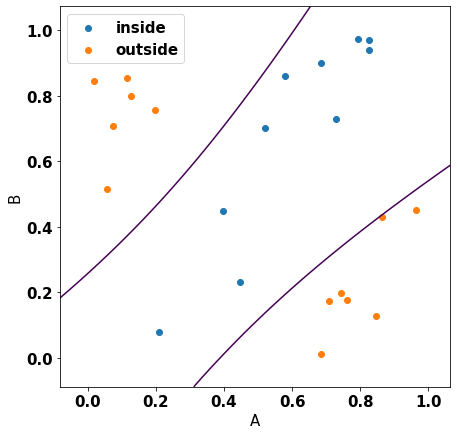

In [24]:
C = Classifier(train1)

In [25]:
dftest1 = C.test(test1)
test1.join(dftest1.set_index(['A', 'B']), on=['A', 'B']).drop(columns=['A2','B2', 'AB','C'])

,A,B,class,class_detected
13,0.261937,0.207272,1,1
26,0.250763,0.884590,-1,-1
4,0.373906,0.380795,1,1
16,0.893944,0.204420,-1,-1
2,0.602314,0.489100,1,1
10,0.338326,0.411363,1,1


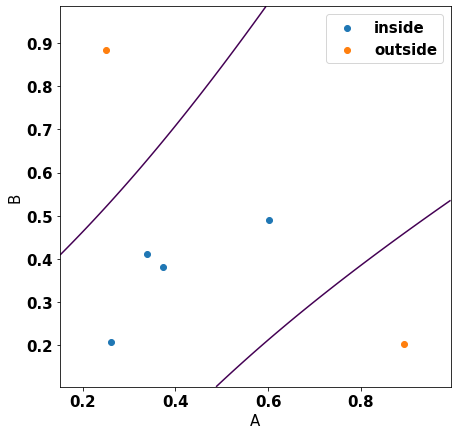

In [26]:
C.plot(test1)

A     0.695921
B     0.150771
A2   -2.393953
B2   -1.923946
AB    1.250788
C     1.043578
Name: 6, dtype: float64


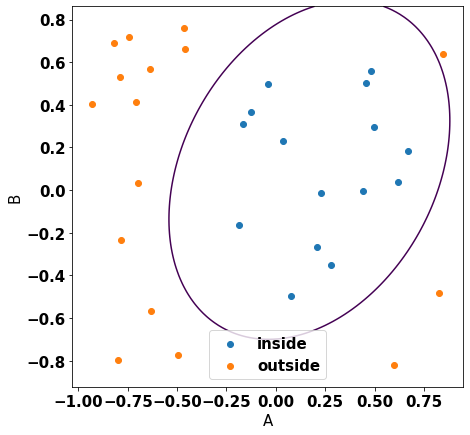

In [14]:
C2 = Classifier(train2)

In [15]:
dftest2 = C2.test(test2)
test2.join(dftest2.set_index(['A', 'B']), on=['A', 'B']).drop(columns=['A2','B2', 'AB','C'])

,A,B,class,class_detected
5,-0.262389,0.446881,1,1
11,0.039664,0.348849,1,1
35,0.829719,-0.199496,-1,-1
10,0.642289,-0.003541,1,1
34,0.866567,0.090772,-1,-1
25,0.822132,-0.157712,-1,-1
38,-0.584470,0.828778,-1,-1
4,0.199091,-0.207021,1,1


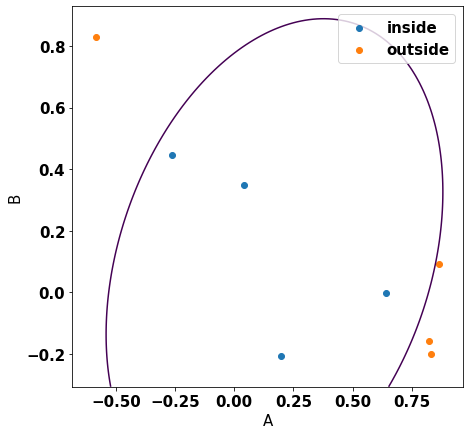

In [16]:
C2.plot(test2)